## Tensorflow加速训练的优化器optimizer

实验：对比SGD和RMSProp的学习速度

In [1]:
import tensorflow as tf
from tensorflow import keras

# 使用sklearn现成的波斯顿房价数据集
from sklearn.datasets import fetch_california_housing

# 做训练集测试集验证集拆分
from sklearn.model_selection import train_test_split

# 对数值数据归一化
from sklearn.preprocessing import StandardScaler

### 1. 下载sklearn的波士顿房价数据集

In [2]:
# 使用这个函数下载波斯顿房价数据集
housing = fetch_california_housing()

In [3]:
# 分割训练集、测试集、验证集
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

In [4]:
# 使用sklearn对数值数据做归一化
scaler = StandardScaler()
# 在训练集上做fit和transform
X_train = scaler.fit_transform(X_train)

# 在测试集和验证集上做transform
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

### 2. 把数据分割为Wide部分输入和Deep部分输入

In [5]:
# A是0~4共5列，B是2~7共6列
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]

# valid和test做同样的处理
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]

### 3. 搭建WideDeep模型

In [6]:
# 输入：wide和deep
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")

# 构造deep部分
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
hidden3 = keras.layers.Dense(30, activation="relu")(hidden2)

# 合并wide和deep
concat = keras.layers.concatenate([input_A, hidden3])

# 输出层
output = keras.layers.Dense(1, name="output")(concat)

### 4. 对参数优化的直观认识

给定参数w、学习率learning_rate、LOSS函数的梯度g，那么参数会这样更新：  
w = w - learning_rate * g

动量、自适应学习率等方法，都是在优化这个更新公式

In [7]:
# 优化器
opt = tf.keras.optimizers.SGD(learning_rate=0.1)
opt

In [8]:
# 待优化参数
w = tf.Variable(10.0)
w

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=10.0>

In [9]:
# 梯度：d(loss)/d(var1) = 2*var1
# w初始化为10，所以首次梯度是20
loss = lambda: w ** 2
loss

<function __main__.<lambda>()>

In [10]:
# 执行参数计算
opt.minimize(loss, [w])

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [11]:
# w = 10 - 0.1*20，第一个1是之前的数字，0.1学习率，后面的20是梯度
w.numpy()

8.0

### 5. 对比SGD和RMSProp的训练速度

#### SGD

In [12]:
# 构造model，注意多输入，单输出
model_sgd = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

# 模型编译
model_sgd.compile(
    loss="mse", 
    optimizer=keras.optimizers.SGD()
)

# 模型训练
history_sgd = model_sgd.fit(
    (X_train_A, X_train_B), 
    y_train, 
    epochs=50,
    validation_data=((X_valid_A, X_valid_B), y_valid)
)

Epoch 1/50
363/363 [==============================] - 1s 2ms/step - loss: 0.8352 - val_loss: 0.5722
Epoch 2/50
363/363 [==============================] - 0s 1ms/step - loss: 0.5100 - val_loss: 0.5064
Epoch 3/50
363/363 [==============================] - 0s 1ms/step - loss: 0.5434 - val_loss: 0.4842
Epoch 4/50
363/363 [==============================] - 0s 994us/step - loss: 0.4354 - val_loss: 0.4780
Epoch 5/50
363/363 [==============================] - 0s 980us/step - loss: 0.4393 - val_loss: 0.4967
Epoch 6/50
363/363 [==============================] - 0s 1ms/step - loss: 0.4116 - val_loss: 0.4258
Epoch 7/50
363/363 [==============================] - 1s 2ms/step - loss: 0.4017 - val_loss: 0.4407
Epoch 8/50
363/363 [==============================] - 0s 1ms/step - loss: 0.3832 - val_loss: 0.4171
Epoch 9/50
363/363 [==============================] - 0s 1ms/step - loss: 0.3727 - val_loss: 0.3955
Epoch 10/50
363/363 [==============================] - 0s 1ms/step - loss: 0.3668 - val_loss: 0.

#### RMSProp

In [13]:
# 构造model，注意多输入，单输出
model_rmsprop = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

# 模型编译
model_rmsprop.compile(
    loss="mse", 
    optimizer=keras.optimizers.RMSprop()
)

# 模型训练
history_rmsprop = model_rmsprop.fit(
    (X_train_A, X_train_B), 
    y_train, 
    epochs=50,
    validation_data=((X_valid_A, X_valid_B), y_valid)
)

Epoch 1/50
363/363 [==============================] - 1s 3ms/step - loss: 0.3019 - val_loss: 0.3368
Epoch 2/50
363/363 [==============================] - 0s 1ms/step - loss: 0.3010 - val_loss: 0.3567
Epoch 3/50
363/363 [==============================] - 1s 1ms/step - loss: 0.3006 - val_loss: 0.3418
Epoch 4/50
363/363 [==============================] - 0s 1ms/step - loss: 0.2998 - val_loss: 0.3585
Epoch 5/50
363/363 [==============================] - 0s 1ms/step - loss: 0.3015 - val_loss: 0.3341
Epoch 6/50
363/363 [==============================] - 0s 1ms/step - loss: 0.2990 - val_loss: 0.3293
Epoch 7/50
363/363 [==============================] - 0s 1ms/step - loss: 0.2961 - val_loss: 0.3403
Epoch 8/50
363/363 [==============================] - 0s 1ms/step - loss: 0.2928 - val_loss: 0.3347
Epoch 9/50
363/363 [==============================] - 0s 1ms/step - loss: 0.2918 - val_loss: 0.3352
Epoch 10/50
363/363 [==============================] - 0s 1ms/step - loss: 0.2943 - val_loss: 0.3531

#### 查看速度对比

In [14]:
import pandas as pd

In [15]:
df = pd.DataFrame({
    "sgd": history_sgd.history["loss"],
    "rmsprop": history_rmsprop.history["loss"]
})

df.head()

,sgd,rmsprop
0,0.835152,0.301941
1,0.510029,0.300994
2,0.543367,0.300553
3,0.435356,0.299793
4,0.439304,0.301549


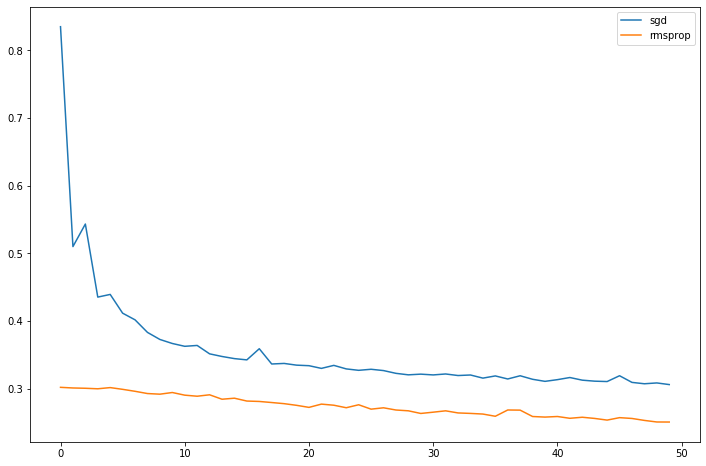

In [16]:
df.plot(figsize=(12, 8))